In [1]:
from data_utils import load_data,flatten_data
from early_model import stacked_lstm
from model_utils import model_pipeline,plot_history,ensemble_predictions
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
train_participant_num = ["C93D","C382D","C382N","C544D","C709N","C788N","P113D","P113N","P191D","P191N","P299D","P300D","P336D","P492D","P492N","P531N","P699D","P890N","P921D","P921N"]
valid_participant_num = ["C67D","C202D","C202N","C256D","C256N","P54D","P54N","P342D","P342N","P487D","P487N","P649N"]

In [3]:
X_train, y_train = load_data(train_participant_num, 'train', downsampling=True,angle_energy=False,augment=False)
X_valid, y_valid = load_data(valid_participant_num, 'validation')

In [4]:
print(X_train.shape,np.unique(y_train[:,0],return_counts=True))

print(X_valid.shape,np.unique(y_valid[:,0],return_counts=True))

(4286, 180, 70) (array([0., 1.], dtype=float32), array([ 844, 3442]))
(2869, 180, 70) (array([0., 1.], dtype=float32), array([ 171, 2698]))


/Users/zekunwu/Library/Python/3.9/lib/python/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2023-03-20 20:31:33.505090: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz



Epoch 1: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 1/20
9/9 [==============================] - 5s 425ms/step - loss: 0.1711 - binary_accuracy: 0.6478 - val_loss: 0.0821 - val_binary_accuracy: 0.9404 - lr: 0.0050

Epoch 2: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 2/20
9/9 [==============================] - 3s 373ms/step - loss: 0.1375 - binary_accuracy: 0.7954 - val_loss: 0.0955 - val_binary_accuracy: 0.9404 - lr: 0.0050

Epoch 3: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 3/20
9/9 [==============================] - 3s 398ms/step - loss: 0.1303 - binary_accuracy: 0.8005 - val_loss: 0.0953 - val_binary_accuracy: 0.9404 - lr: 0.0050

Epoch 4: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 4/20
9/9 [==============================] - 3s 365ms/step - loss: 0.1293 - binary_accuracy: 0.8033 - val_loss: 0.0906 - val_binary_accuracy: 0.9404 - lr: 0.0050

Epoch 5: Learni

/Users/zekunwu/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zekunwu/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zekunwu/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


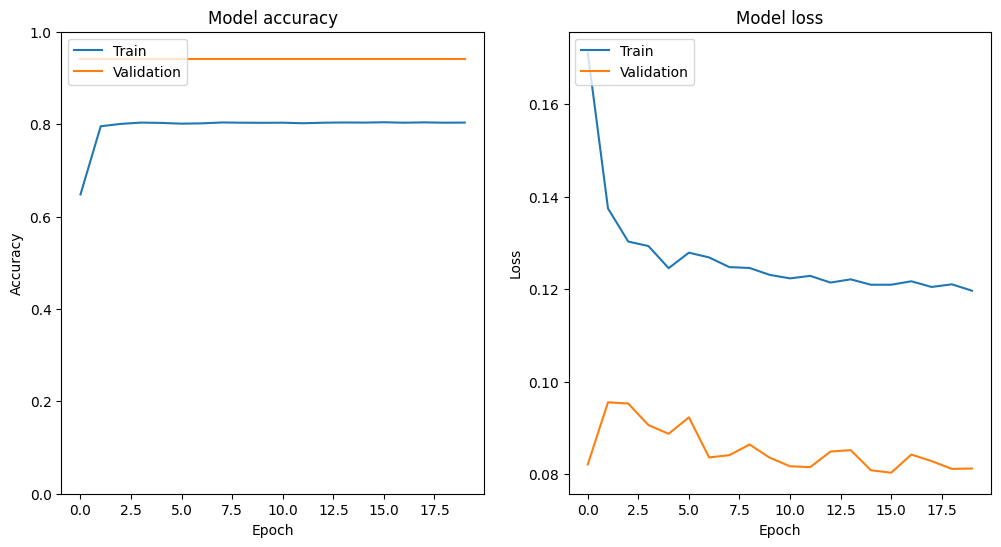

In [5]:
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = y_train.shape[1]
model = stacked_lstm(input_shape,num_classes)
y_pred, y_true, H = model_pipeline(model, X_train, y_train, X_valid, y_valid, epoch=20)
plot_history(H)

In [6]:
X_train_flatten,y_train_flatten = flatten_data(X_train,y_train)
X_valid_flatten,y_valid_flatten = flatten_data(X_valid,y_valid)

In [7]:
print(X_train_flatten.shape,np.unique(y_train_flatten[:],return_counts=True))

print(X_valid_flatten.shape,np.unique(y_valid_flatten[:],return_counts=True))

(4286, 12600) (array([0, 1]), array([3442,  844]))
(2869, 12600) (array([0, 1]), array([2698,  171]))


In [8]:
X_train_rf = X_train[:,:,0:66]
X_valid_rf = X_valid[:,:,0:66]
X_train_svm = X_train[:,:,66:70]
X_valid_svm = X_valid[:,:,66:70]

In [9]:
X_train_rf,y_train_rf = flatten_data(X_train_rf,y_train)
X_train_svm,y_train_svm = flatten_data(X_train_svm,y_train)

X_valid_rf,y_valid_rf = flatten_data(X_valid_rf,y_valid)
X_valid_svm,y_valid_svm = flatten_data(X_valid_svm,y_valid)

In [10]:
rf = RandomForestClassifier()
svm = SVC(probability=True)

rf.fit(X_train_rf,y_train_rf)
svm.fit(X_train_svm,y_train_svm)

SVC(probability=True)

In [11]:
rf_pred = rf.predict_proba(X_valid_rf)
svm_pred = svm.predict_proba(X_valid_svm)

In [12]:
ensemble_pred = ensemble_predictions(rf_pred,svm_pred)
print(classification_report(y_valid_rf,ensemble_pred))
print(confusion_matrix(y_valid_rf,ensemble_pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      2698
           1       0.29      0.49      0.37       171

    accuracy                           0.90      2869
   macro avg       0.63      0.71      0.66      2869
weighted avg       0.93      0.90      0.91      2869

[[2497  201]
 [  87   84]]
